# Part 2: Generate the embeddings for Experiment 1, 4.4.1 Multiclass Classification of Images

In [ ]:
# Packages 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
 
import os
import argparse
import numpy as np
#from models import *
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

import sys
import os
import sklearn
from sklearn.metrics import confusion_matrix

import pandas as pd

import sys

In [4]:
embed_dim = 16

# DLA Model

In [5]:
'''DLA in PyTorch.
Reference:
    Deep Layer Aggregation. https://arxiv.org/abs/1707.06484
'''
'''
Code taken from (with a permission published on the website https://github.com/kuangliu/pytorch-cifar/blob/master/LICENSE)
https://github.com/kuangliu/pytorch-cifar/blob/master/models/dla.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(DLA, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear1 = nn.Linear(512, embed_dim)
        self.linear2 = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1) 
        out = self.linear1(out)
        emb = out
        out = self.linear2(out)
        return F.softmax(out, dim=1), emb


def test():
    net = DLA()
    print(net)
    x = torch.randn(1, 3, 32, 32)
    y = net(x)
    print(y)


if __name__ == '__main__':
    test()

DLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_node): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1

In [6]:
# After training etc. possible to just load the model
# PLEASE NOTE: Here, due to the size of the model, we do not attach it, however, we show the loading as an example how to do it

#net_pred = DLA()
#net_pred.load_state_dict(torch.load('FinalModel_0.904DLA_CIFAR10.pt'))

<All keys matched successfully>

In [7]:
# Check the number of parameters

[param.nelement() for param in net_pred.parameters()]

sum([param.nelement() for param in net_pred.parameters()])

16294634

In [8]:
# Transformation necessary to apply to the images

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
#Trainset

trainset = torchvision.datasets.CIFAR10(
    root='/workspace/SPC_Embeddings/cifar-10-batches-py', train=True, download=False, transform=transform_train)

In [10]:
#Testset

testset = torchvision.datasets.CIFAR10(
    root='/workspace/SPC_Embeddings/cifar-10-batches-py', train=False, download=False, transform=transform_test)

# Obtain predictions and embeddings

## Phase I: Training data

In [25]:
numbers_idx = range(0, 50500, 500) # Up to 50500 as the last number is not included

In [34]:
# Perform check
numbers_idx[100] 


50000

In [26]:
# The length of the array
len(numbers_idx)

101

In [13]:
# Function for turning the numbers into strings for adding into the file names
def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

In [33]:
# Generate and save the embeddings for Phase I: Training Data

for i in range(1,101):
    
    # Create subset of train data with size 500
    trainset_subset = torch.utils.data.Subset(trainset, range(numbers_idx[i-1], numbers_idx[i]))   
    trainloader_indices = torch.utils.data.DataLoader(trainset_subset, batch_size=1)
    
    # Create containers to collect embeddings, predictions and true labels
    predictions_label = []
    predictions_output = []
    embed_list = []
    train_labels = []
    
    # Run classification and append the results
    for s, data in enumerate(trainloader_indices): 
        net_pred.eval()
        x, y_true = data
        prediction, embed = net_pred(x)
        prediction2 = prediction.detach().numpy()
        current_class = y_true   
        klasse = np.argmax(prediction2, axis=-1)
        
        embed_list.append(embed.detach().numpy())  
        predictions_output.append(prediction2)  
        predictions_label.append(klasse.astype(int)) 
        train_labels.append(y_true.detach().numpy())  
    
    # Create a table with predictions and true labels
    predictions_traindata = pd.DataFrame(np.squeeze(predictions_output))
    predictions_traindata['binary'] = predictions_label
    predictions_traindata['true'] = train_labels
    
    # Save the files as .txt
    
    f = open(to_str(numbers_idx[i-1]) + 'to' + to_str(numbers_idx[i]) + 'train_labels_probabilities_classificationCIFAR10.txt', 'w')
    np.savetxt(f, predictions_traindata)
    f.close()
    
    f = open(to_str(numbers_idx[i-1]) + 'to' + to_str(numbers_idx[i]) + 'train_embeddings16d_classificationCIFAR10.txt', 'w')
    np.savetxt(f, np.squeeze(embed_list))
    f.close()
    

## Phase II, in-control: Test data

In [21]:
numbers_idx_test = range(0, 10500, 500) # Up to 10500 as the last number is not included

In [37]:
# Perform check
numbers_idx_test[20]

10000

In [38]:
# Length of the array
len(numbers_idx_test)

21

In [39]:
# Generate and save the embeddings for Phase II, in-control: Test Data


for i in range(1,21):
    
    # Create subset of test data with size 500
    testset_subset = torch.utils.data.Subset(testset, range(numbers_idx_test[i-1], numbers_idx_test[i]))   
    testloader_indices = torch.utils.data.DataLoader(testset_subset, batch_size=1)
    
    # Create containers to collect embeddings, predictions and true labels
    predictions_label = []
    predictions_output = []
    embed_list = []
    train_labels = []
    
    # Run classification and append the results
    for s, data in enumerate(testloader_indices): 
        net_pred.eval()
        x, y_true = data
        prediction, embed = net_pred(x)
        prediction2 = prediction.detach().numpy()
        current_class = y_true   
        klasse = np.argmax(prediction2, axis=-1)
        
        embed_list.append(embed.detach().numpy())  
        predictions_output.append(prediction2)  
        predictions_label.append(klasse.astype(int)) 
        train_labels.append(y_true.detach().numpy())  
    
    # Create a table with predictions and true labels
    predictions_testdata = pd.DataFrame(np.squeeze(predictions_output))
    predictions_testdata['binary'] = predictions_label
    predictions_testdata['true'] = train_labels
    
    # Save the files as .txt
    
    f = open(to_str(numbers_idx[i-1]) + 'to' + to_str(numbers_idx[i]) + 'test_labels_probabilities_classificationCIFAR10.txt', 'w')
    np.savetxt(f, predictions_testdata)
    f.close()
    
    f = open(to_str(numbers_idx[i-1]) + 'to' + to_str(numbers_idx[i]) + 'test_embeddings16d_classificationCIFAR10.txt', 'w')
    np.savetxt(f, np.squeeze(embed_list))
    f.close()
    


# Phase II, out-of-control: Out-of-control data from CIFAR-100

In [46]:
# Get the dataset
phase2_data = CIFAR100(download=True, root='./cifar-100-batches-py', transform=transform_test)

Files already downloaded and verified


In [47]:
# Filtering of the image indices

train_indices, kangaroo_indices, butterfly_indices, rocket_indices, other_indices = [], [], [], [], []
train_idx, kangaroo_idx, butterfly_idx, rocket_idx = phase2_data.class_to_idx['train'], phase2_data.class_to_idx['kangaroo'], phase2_data.class_to_idx['butterfly'], phase2_data.class_to_idx['rocket']
for i in range(len(phase2_data)):
    current_class = phase2_data[i][1]
    if current_class == train_idx:
        train_indices.append(i)
    elif current_class == kangaroo_idx:
        kangaroo_indices.append(i)
    elif current_class == butterfly_idx:
        butterfly_indices.append(i)
    elif current_class == rocket_idx:
        rocket_indices.append(i)
    else:
        other_indices.append(i)

In [48]:
# Take only 100 images for each of the classes for Phase II dataset

train_indices = train_indices[:int(0.2 * len(train_indices))]
kangaroo_indices = kangaroo_indices[:int(0.2 * len(kangaroo_indices))]
butterfly_indices = butterfly_indices[:int(0.2 * len(butterfly_indices))]
rocket_indices = rocket_indices[:int(0.2 * len(rocket_indices))]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


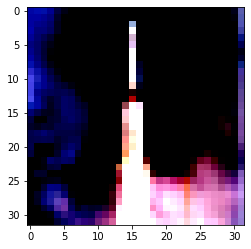

In [55]:
# Illustration of one of the pictures

img_phase2, label_phase2 = phase2_data[10737] # image of a rocket
plt.imshow(img_phase2.permute(1, 2, 0))

plt.show()

In [63]:
# Define the names of the classes
phaseII_indices = [train_indices, kangaroo_indices, butterfly_indices, rocket_indices]

phaseII_classes = ["train", "kangaroo", "butterfly", "rocket"]

In [69]:
# Generate and save the embeddings for Phase II, out-of-control: Out-of-control data from CIFAR-100

for i in range(0,4):
    
    # Create subset of train data with size 100
    trainset_subset = torch.utils.data.Subset(phase2_data, phaseII_indices[i])   
    trainloader_indices = torch.utils.data.DataLoader(trainset_subset, batch_size=1)
    
    # Create containers to collect embeddings, predictions and true labels
    predictions_label = []
    predictions_output = []
    embed_list = []
    train_labels = []
    
    # Run classification and append the results
    for s, data in enumerate(trainloader_indices): 
        net_pred.eval()
        x, y_true = data
        prediction, embed = net_pred(x)
        prediction2 = prediction.detach().numpy()
        current_class = y_true   
        klasse = np.argmax(prediction2, axis=-1)
        
        embed_list.append(embed.detach().numpy())  
        predictions_output.append(prediction2)  
        predictions_label.append(klasse.astype(int)) 
        train_labels.append(y_true.detach().numpy())  

    # Save the files as .txt
    
    f = open(phaseII_classes[i] + 'PHASEII_embeddings16d_classificationCIFAR10.txt', 'w')
    np.savetxt(f, np.squeeze(embed_list))
    f.close()
    
    f = open(phaseII_classes[i] + 'PHASEII_predictions_classificationCIFAR10.txt', 'w')
    np.savetxt(f, np.squeeze(predictions_output))
    f.close()
    
    f = open(phaseII_classes[i] + 'PHASEII_binarypredictions_classificationCIFAR10.txt', 'w')
    np.savetxt(f, np.squeeze(predictions_label))
    f.close()

## Remark: After generating and saving the embeddings, the rest of the analysis and monitoring happens in R 